# Benchmark Results
This notebook visualizes the output from the different models on different classification problems

In [20]:
import collections
import glob
import itertools
import json
import os

import numpy as np
import pandas as pd
import plotnine
import svgutils.transform as sg
from svgutils.compose import SVG, Figure, Panel
from plotnine import *

from saged.utils import split_sample_names, create_dataset_stat_df, get_dataset_stats, parse_map_file

## Binary Prediction

In [3]:
top_five_tissues = ['Blood', 'Breast', 'Stem_Cell', 'Cervix', 'Brain']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Stem_Cell'), ('Blood', 'Cervix')]

In [4]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

720

In [5]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'three_layer_net')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'five_layer_net')

## Pairwise comparisons

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary.svg


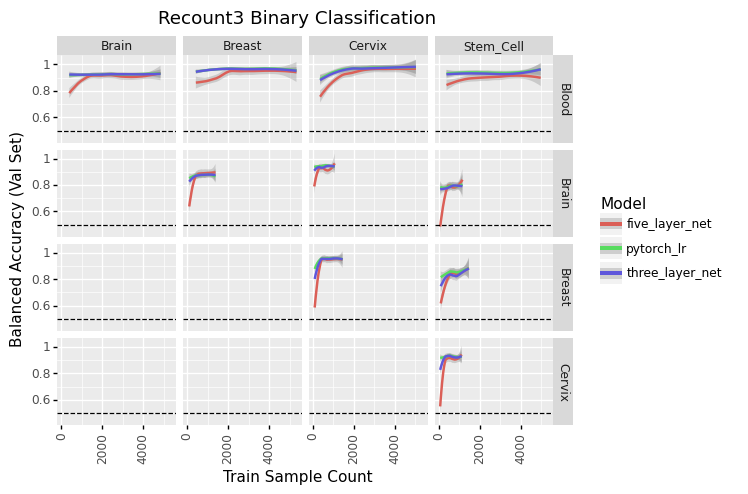

<ggplot: (8788371196005)>

In [6]:
plot_df = run_results[run_results['correction_method'] == 'unmodified']
plot_df = plot_df[plot_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()

plot += geom_hline(yintercept=.5, linetype='dashed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary.svg')
plot

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary_signal_removed.svg


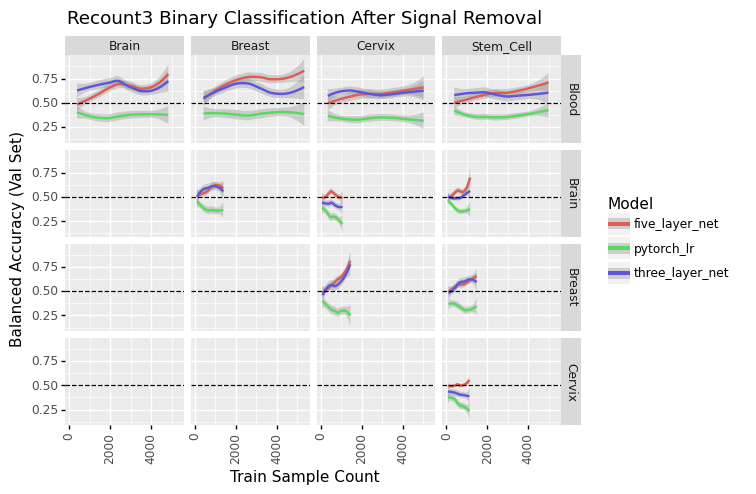

<ggplot: (8788371204253)>

In [7]:
plot_df = run_results[run_results['correction_method'] == 'signal_removed']
plot_df = plot_df[plot_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')


plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification After Signal Removal')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary_signal_removed.svg')
plot

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary_split_limma.svg


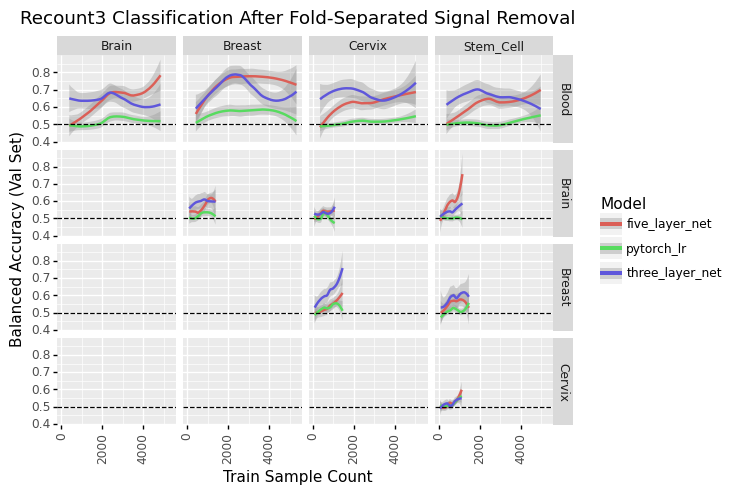

<ggplot: (8788371112505)>

In [8]:
plot_df = run_results[run_results['correction_method'] == 'split_signal']
plot_df = plot_df[plot_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]

plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')

plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Classification After Fold-Separated Signal Removal')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary_split_limma.svg')
plot

### Combine figures

In [31]:
# You have to look at the xml content of the svgs to determine their width and height to get
# the new figure to be the correct size :(
fig = sg.SVGFigure("356pt", "969pt")

fig1 = sg.fromfile('../../figures/recount_binary.svg')
fig2 = sg.fromfile('../../figures/recount_binary_signal_removed.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot1.moveto(0, 0, )
plot2.moveto(425, 0, )

fig.append([plot1, plot2])

fig.save('../../figures/recount_binary_combined.svg')

## All Tissue Predictions

In [9]:
in_files = glob.glob('../../results/all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/all-tissue.full_data_pytorch_lr_2.tsv', '../../results/all-tissue.pytorch_lr_2.tsv', '../../results/all-tissue.batch-skl-lr_0.tsv', '../../results/all-tissue.deep_net_1.tsv', '../../results/all-tissue.logistic_regression_2.tsv']


In [10]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass.svg


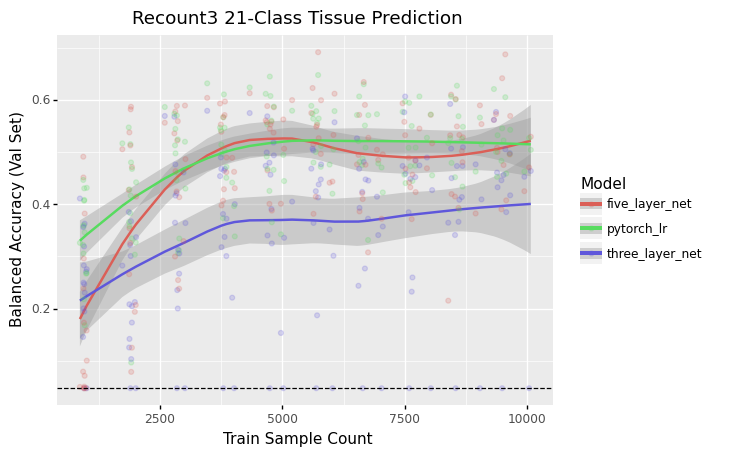

<ggplot: (8754347795941)>

In [11]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 

plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 21-Class Tissue Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass.svg')
plot

### All tissue signal removed

In [12]:
in_files = glob.glob('../../results/all-tissue.*.tsv')
in_files = [f for f in in_files if 'signal_removed' in f]
print(in_files[:5])

['../../results/all-tissue.pytorch_lr_2_signal_removed.tsv', '../../results/all-tissue.deep_net_2_signal_removed.tsv', '../../results/all-tissue.deep_net_1_signal_removed.tsv', '../../results/all-tissue.logistic_regression_2_signal_removed.tsv', '../../results/all-tissue.pytorch_lr_1_signal_removed.tsv']


In [13]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-3])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-3]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_signal_removed.svg


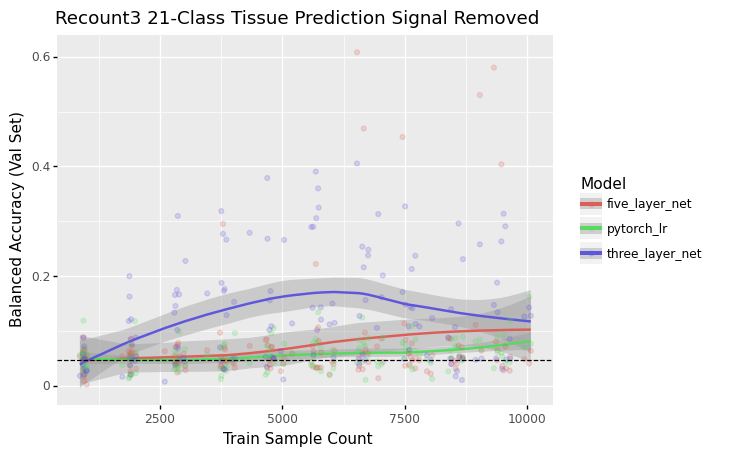

<ggplot: (8754345249833)>

In [14]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 

plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 21-Class Tissue Prediction Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_signal_removed.svg')
plot

## All tissue sample split

In [15]:
in_files = glob.glob('../../results/all-tissue_sample-split*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/all-tissue_sample-split.batch-skl-lr_2.tsv', '../../results/all-tissue_sample-split.deep_net_1.tsv', '../../results/all-tissue_sample-split.pytorch_lr_0.tsv', '../../results/all-tissue_sample-split.pytorch_supervised_0.tsv', '../../results/all-tissue_sample-split.deep_net_0.tsv']


In [16]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue_sample-split.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
    new_df['split'] = 'sample'
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])

In [17]:
more_files = glob.glob('../../results/all-tissue.*')
more_files = [f for f in more_files if 'be_corrected' not in f]
print(more_files[:5])

['../../results/all-tissue.full_data_pytorch_lr_2.tsv', '../../results/all-tissue.pytorch_lr_2.tsv', '../../results/all-tissue.batch-skl-lr_0.tsv', '../../results/all-tissue.deep_net_1.tsv', '../../results/all-tissue.logistic_regression_2.tsv']


In [18]:
for path in more_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
    new_df['split'] = 'study'
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_sample_split.svg


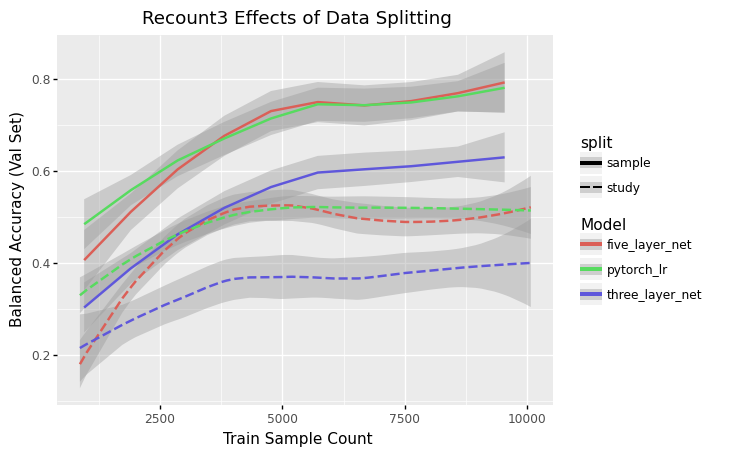

<ggplot: (8754345233057)>

In [19]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth(aes(linetype='split'))
plot += ggtitle('Recount3 Effects of Data Splitting')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_sample_split.svg')
plot

## Pretraining

In [20]:
in_files = glob.glob('../../results/study-split.*.tsv')
print(in_files[:5])

['../../results/study-split.pytorch_supervised_2.tsv', '../../results/study-split.deep_net_2.tsv', '../../results/study-split.logistic_regression_2.tsv', '../../results/study-split.pytorch_lr_2.tsv', '../../results/study-split.logistic_regression_1.tsv']


In [21]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv')
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')
#tissue_metrics['Model'] = tissue_metrics['Model'] + '_' + tissue_metrics['is_pretrained']
tissue_metrics['pretrained'] = True
tissue_metrics.loc[tissue_metrics['is_pretrained'] == 'not_pretrained', 'pretrained'] = False
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,Model,seed,train_count,pretrained
0,0.550241,0.307520,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,pretrained,"11,11,11,11,11,11,5,4,4,4,6,6,6,6,6,3,3,3,3,3,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,478,True
1,0.336551,0.096469,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,not_pretrained,"0,0,0,0,0,0,5,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,478,False
2,0.593243,0.324776,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,pretrained,"11,11,11,5,5,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,957,True
3,0.424748,0.058479,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,not_pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,957,False
4,0.635805,0.336969,"SRP034737,SRP010678,SRP009105,SRP009251,SRP007...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1435,0.3,pretrained,"11,11,11,11,11,11,5,4,4,4,11,11,11,11,11,3,3,3...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,1435,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.643312,0.530296,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",3375,0.8,not_pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,3375,False
96,0.651274,0.527851,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",3797,0.9,pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,3797,True
97,0.651274,0.527851,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",3797,0.9,not_pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,3797,False
98,0.633758,0.550480,"SRP007461,SRP043368,SRP038702,SRP015964,SRP008...","SRR037223,SRR1200511,SRR957903,SRR1182358,SRR2...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",4219,1.0,pretrained,"4,4,4,11,11,11,11,11,3,3,3,3,3,3,3,3,3,8,8,8,8...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",logistic_regression,0,4219,True


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_pretraining.svg


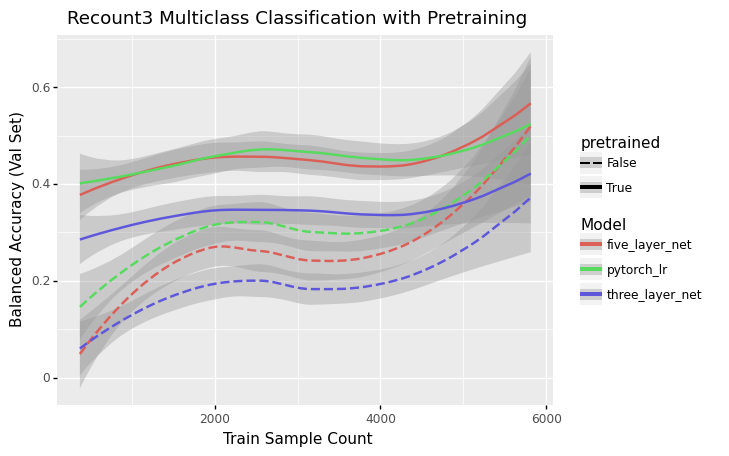

<ggplot: (8754345745677)>

In [22]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth(aes(linetype='pretrained'))
plot += ggtitle('Recount3 Multiclass Classification with Pretraining')
plot += scale_linetype_manual(['dashed', 'solid'])
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_pretraining.svg')
plot

## Sex Prediction

In [23]:
in_files = glob.glob('../../results/sample-split-sex-prediction.*.tsv')
print(in_files[:5])

['../../results/sample-split-sex-prediction.pytorch_supervised_0.tsv', '../../results/sample-split-sex-prediction.logistic_regression_2.tsv', '../../results/sample-split-sex-prediction.pytorch_lr_0.tsv', '../../results/sample-split-sex-prediction.deep_net_0.tsv', '../../results/sample-split-sex-prediction.pytorch_supervised_2.tsv']


In [24]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv')
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.696493,0.697076,"SRP149047,SRP166169,SRP181468,SRP091785,SRP076...","SRR8587433,SRR1643319,SRR6366375,SRR3637397,SR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",1882,0.1,"0,1,1,0,1,0,1,1,1,1,0,0,0,1,0,1,0,1,1,0,1,0,1,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,1882
1,0.866312,0.866305,"SRP149047,SRP166169,SRP181468,SRP091785,SRP076...","SRR8587433,SRR1643319,SRR6366375,SRR3637397,SR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",3764,0.2,"0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,3764
2,0.578108,0.575128,"SRP149047,SRP166169,SRP181468,SRP091785,SRP076...","SRR8587433,SRR1643319,SRR6366375,SRR3637397,SR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",5646,0.3,"0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,5646
3,0.852285,0.852057,"SRP110765,SRP149047,SRP166169,SRP181468,SRP091...","SRR8587433,SRR1643319,SRR6366375,SRR3637397,SR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",7528,0.4,"0,0,1,0,1,0,1,1,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,7528
4,0.574283,0.578715,"SRP071026,SRP110765,SRP149047,SRP166169,SRP181...","SRR8587433,SRR1643319,SRR6366375,SRR3637397,SR...","SRR5282595,SRR5975004,ERR2278255,SRR3236008,SR...",9410,0.5,"1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,...","0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,...","{""female"": 0, ""male"": 1}",three_layer_net,0,9410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.946652,0.946682,"SRP126691,ERP107715,SRP028822,SRP115446,SRP127...","SRR3438713,SRR1643425,SRR8288486,SRR3593238,SR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",11292,0.6,"1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,11292
46,0.949841,0.949874,"SRP126691,ERP107715,SRP028822,SRP115446,SRP127...","SRR3438713,SRR1643425,SRR8288486,SRR3593238,SR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",13174,0.7,"1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,13174
47,0.949628,0.949633,"SRP126691,ERP107715,SRP028822,SRP115446,SRP127...","SRR3438713,SRR1643425,SRR8288486,SRR3593238,SR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",15056,0.8,"1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,15056
48,0.951328,0.951385,"SRP126691,ERP107715,SRP028822,SRP115446,SRP127...","SRR3438713,SRR1643425,SRR8288486,SRR3593238,SR...","SRR7155727,SRR8080221,ERR2271020,SRR8908377,SR...",16938,0.9,"1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,...","{""female"": 0, ""male"": 1}",logistic_regression,0,16938


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_samplewise.svg


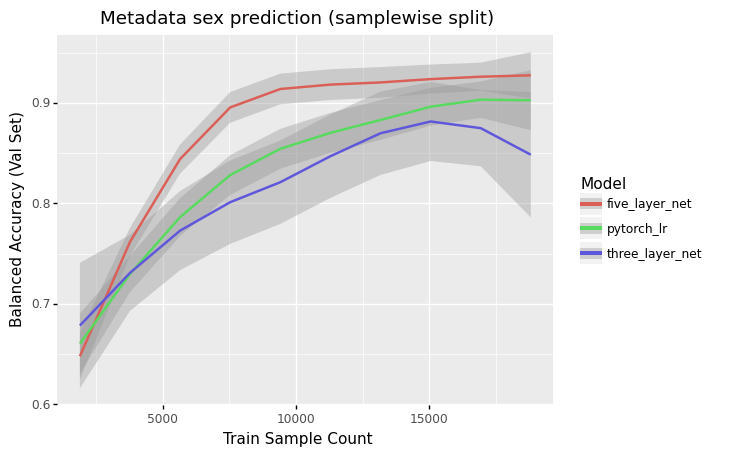

<ggplot: (8754345745761)>

In [25]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Metadata sex prediction (samplewise split)')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_samplewise.svg')
plot

### Study Level

In [26]:
in_files = glob.glob('../../results/study-split-sex-prediction.*.tsv')
print(in_files[:5])

['../../results/study-split-sex-prediction.pytorch_lr_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_1.tsv', '../../results/study-split-sex-prediction.logistic_regression_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_0.tsv', '../../results/study-split-sex-prediction.pytorch_lr_2.tsv']


In [27]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.590566,0.589163,"ERP105640,SRP062062,SRP029262,ERP111913,SRP186...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",1756,0.1,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1756
1,0.598623,0.580422,"ERP105640,SRP062062,ERP004151,SRP029262,ERP111...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",3513,0.2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,3513
2,0.602149,0.583600,"ERP105640,SRP062062,ERP004151,SRP029262,ERP111...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",5270,0.3,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,5270
3,0.828101,0.829663,"ERP105640,SRP062062,ERP004151,SRP029262,ERP111...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",7027,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,7027
4,0.814840,0.817002,"ERP105640,SRP062062,ERP004151,SRP029262,ERP111...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",8784,0.5,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,8784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.781873,0.785792,"SRP124307,SRP200094,SRP067928,SRP022361,SRP042...","ERR1991712,SRR5981882,SRR1282976,SRR957962,SRR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",11917,0.6,"1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,11917
46,0.883429,0.878961,"SRP124307,SRP200094,SRP067928,SRP022361,SRP042...","ERR1991712,SRR5981882,SRR1282976,SRR957962,SRR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",13903,0.7,"1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,13903
47,0.834562,0.836648,"SRP124307,SRP200094,SRP067928,SRP022361,SRP042...","ERR1991712,SRR5981882,SRR1282976,SRR957962,SRR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",15889,0.8,"0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,15889
48,0.766585,0.774727,"SRP124307,SRP200094,SRP067928,SRP022361,SRP042...","ERR1991712,SRR5981882,SRR1282976,SRR957962,SRR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",17875,0.9,"1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,17875


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_studywise.svg


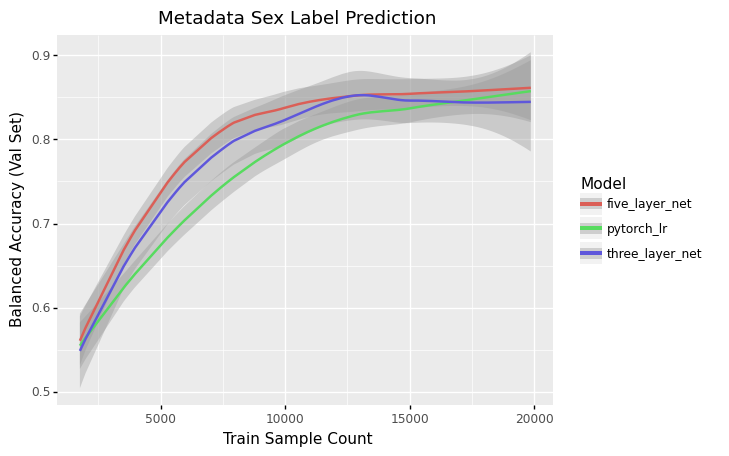

<ggplot: (8754345335801)>

In [28]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Metadata Sex Label Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_studywise.svg')
plot

### Study level signal removed

In [29]:
in_files = glob.glob('../../results/sex-prediction-signal-removed.*.tsv')
print(in_files[:5])

['../../results/sex-prediction-signal-removed.deep_net_1.tsv', '../../results/sex-prediction-signal-removed.pytorch_supervised_2.tsv', '../../results/sex-prediction-signal-removed.pytorch_lr_1.tsv', '../../results/sex-prediction-signal-removed.logistic_regression_0.tsv', '../../results/sex-prediction-signal-removed.deep_net_0.tsv']


In [30]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sex-prediction-signal-removed.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_signal_removed.svg


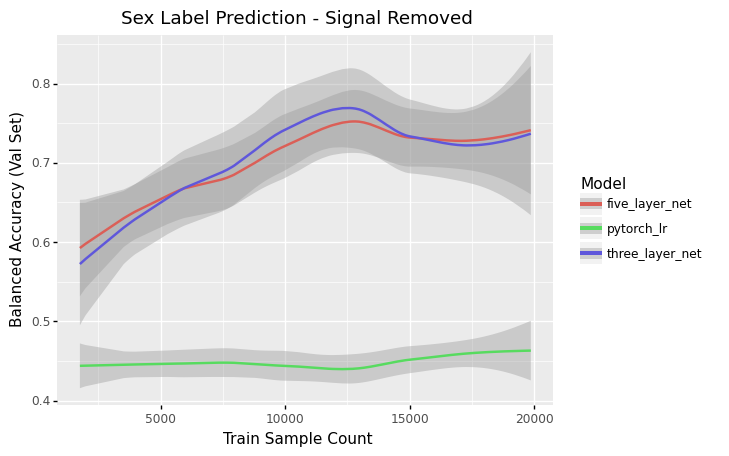

<ggplot: (8754347974681)>

In [31]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Sex Label Prediction - Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_signal_removed.svg')
plot

### Study level split signal removed

In [32]:
in_files = glob.glob('../../results/sex-prediction-split-signal.*.tsv')
print(in_files[:5])

['../../results/sex-prediction-split-signal.logistic_regression_0.tsv', '../../results/sex-prediction-split-signal.pytorch_lr_1.tsv', '../../results/sex-prediction-split-signal.pytorch_lr_2.tsv', '../../results/sex-prediction-split-signal.pytorch_lr_0.tsv', '../../results/sex-prediction-split-signal.pytorch_supervised_0.tsv']


In [33]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sex-prediction-split-signal.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.506421,0.507741,"SRP044296,SRP162285,SRP062062,SRP211963,SRP198...","ERR982702,SRR7187177,SRR1782935,SRR3185939,SRR...","SRR3727800,SRR3727801,SRR3727803,SRR3727804,SR...",1799,0.1,"1,0,1,1,1,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,...","0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,...","{""female"": 0, ""male"": 1}",logistic_regression,0,1799
1,0.593055,0.594182,"SRP044296,SRP162285,SRP001558,SRP062062,SRP211...","ERR982702,SRR7187177,SRR1782935,SRR3185939,SRR...","SRR3727800,SRR3727801,SRR3727803,SRR3727804,SR...",3599,0.2,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,...","0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,...","{""female"": 0, ""male"": 1}",logistic_regression,0,3599
2,0.564478,0.565525,"SRP056199,SRP044296,SRP162285,SRP001558,SRP062...","ERR982702,SRR7187177,SRR1782935,SRR3185939,SRR...","SRR3727800,SRR3727801,SRR3727803,SRR3727804,SR...",5398,0.3,"1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,...","0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,...","{""female"": 0, ""male"": 1}",logistic_regression,0,5398
3,0.536987,0.538081,"SRP056199,SRP044296,SRP162285,SRP001558,SRP057...","ERR982702,SRR7187177,SRR1782935,SRR3185939,SRR...","SRR3727800,SRR3727801,SRR3727803,SRR3727804,SR...",7198,0.4,"0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,...","0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,...","{""female"": 0, ""male"": 1}",logistic_regression,0,7198
4,0.512751,0.512441,"SRP056199,SRP044296,SRP162285,SRP036595,SRP001...","ERR982702,SRR7187177,SRR1782935,SRR3185939,SRR...","SRR3727800,SRR3727801,SRR3727803,SRR3727804,SR...",8998,0.5,"0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,...","0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,...","{""female"": 0, ""male"": 1}",logistic_regression,0,8998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.861727,0.868749,"SRP154388,SRP089857,SRP048647,SRP032539,SRP078...","SRR5225786,SRR5176664,SRR7195860,ERR1880137,SR...","SRR4098610,SRR6261037,SRR1945300,SRR1945301,SR...",11815,0.6,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,...","0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,...","{""female"": 0, ""male"": 1}",five_layer_net,1,11815
46,0.642317,0.612199,"SRP154388,SRP089857,SRP048647,SRP032539,SRP078...","SRR5225786,SRR5176664,SRR7195860,ERR1880137,SR...","SRR4098610,SRR6261037,SRR1945300,SRR1945301,SR...",13784,0.7,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,...","{""female"": 0, ""male"": 1}",five_layer_net,1,13784
47,0.644404,0.646806,"SRP154388,SRP089857,SRP048647,SRP032539,SRP078...","SRR5225786,SRR5176664,SRR7195860,ERR1880137,SR...","SRR4098610,SRR6261037,SRR1945300,SRR1945301,SR...",15753,0.8,"0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,...","0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,...","{""female"": 0, ""male"": 1}",five_layer_net,1,15753
48,0.673363,0.663627,"SRP154388,SRP089857,SRP048647,SRP032539,SRP078...","SRR5225786,SRR5176664,SRR7195860,ERR1880137,SR...","SRR4098610,SRR6261037,SRR1945300,SRR1945301,SR...",17722,0.9,"0,1,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,...","0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,...","{""female"": 0, ""male"": 1}",five_layer_net,1,17722


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_split_signal.svg


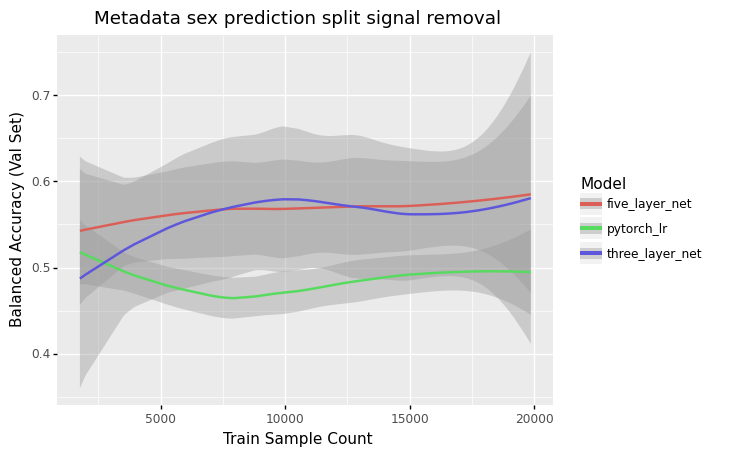

<ggplot: (8754345674825)>

In [34]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Metadata sex prediction split signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_split_signal.svg')
plot

In [35]:
#create new SVG figure
fig = sg.SVGFigure("328pt", "940")

# load matpotlib-generated figures
fig1 = sg.fromfile('../../figures/sex_prediction_studywise.svg')
fig2 = sg.fromfile('../../figures/sex_prediction_signal_removed.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot1.moveto(0, 0,)
plot2.moveto(415, 0,)

fig.append([plot1, plot2,])

fig.save('../../figures/sex_prediction.svg')

## GTEx All Tissues

In [36]:
in_files = glob.glob('../../results/gtex-all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-all-tissue.deep_net_1.tsv', '../../results/gtex-all-tissue.deep_net_0.tsv', '../../results/gtex-all-tissue.pytorch_lr_0.tsv', '../../results/gtex-all-tissue.pytorch_lbfgs_2.tsv', '../../results/gtex-all-tissue.pytorch_supervised_1.tsv']


In [37]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_multiclass.svg


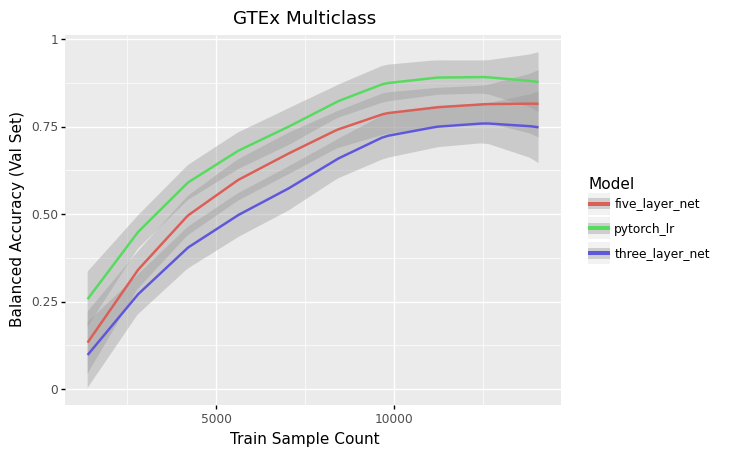

<ggplot: (8754348219805)>

In [38]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
#plot += geom_point(alpha=.2)
plot += ggtitle('GTEx Multiclass')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_multiclass.svg')
plot

In [39]:
in_files = glob.glob('../../results/gtex-all-tissue-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-all-tissue-signal-removed.logistic_regression_0.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_lr_0.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_lbfgs_2.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_0.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_1.tsv']


In [40]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('gtex-all-tissue-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_multiclass_signal_removed.svg


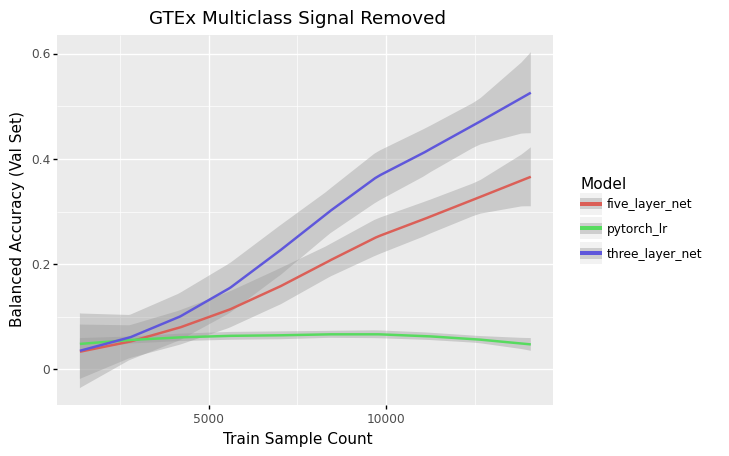

<ggplot: (8754345548721)>

In [41]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('GTEx Multiclass Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_multiclass_signal_removed.svg')
plot

## Binary Predictions

In [42]:
top_five_tissues = ['Blood', 'Brain', 'Skin', 'Esophagus', 'Blood_Vessel']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Brain'), ('Blood', 'Skin'), ('Blood', 'Esophagus')]

In [43]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

120

In [44]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
        
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'three_layer_net')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_pairwise.svg


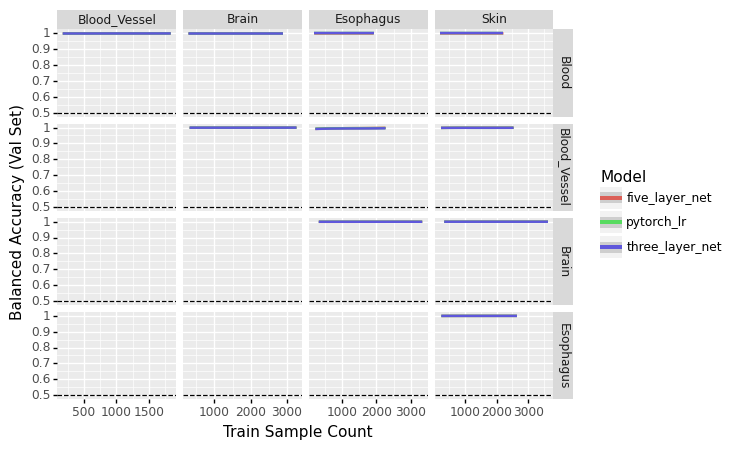

<ggplot: (8754348108161)>

In [45]:
plot_df = run_results[run_results['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot_df = plot_df[plot_df['correction_method'] == 'unmodified']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'], scales='free')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_pairwise.svg')
plot

In [46]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex-signal-removed.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

120

In [47]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
        
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
        
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'three_layer_net')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_pairwise_signal_removed.svg


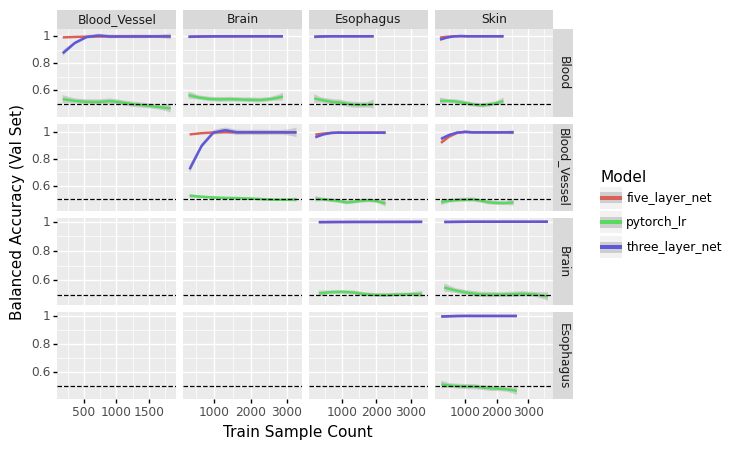

<ggplot: (8754345717509)>

In [48]:
plot_df = run_results[run_results['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'], scales='free')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_pairwise_signal_removed.svg')
plot

### Combine GTEx

In [49]:
#create new SVG figure
fig = sg.SVGFigure("16cm", "16cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('../../figures/gtex_multiclass.svg')
fig2 = sg.fromfile('../../figures/gtex_multiclass_signal_removed.svg')
fig3 = sg.fromfile('../../figures/gtex_pairwise.svg')
fig4 = sg.fromfile('../../figures/gtex_pairwise_signal_removed.svg')

plot1 = fig1.getroot()
plot3 = fig2.getroot()
plot2 = fig3.getroot()
plot4 = fig4.getroot()

plot1.moveto(0, 0, scale_x=.5, scale_y=.5)
plot2.moveto(0, 162, scale_x=.5, scale_y=.5)
plot3.moveto(210, 0, scale_x=.5, scale_y=.5)
plot4.moveto(210, 162, scale_x=.5, scale_y=.5)

fig.append([plot1, plot2, plot3, plot4])

fig.save('../../figures/gtex_combined.svg')

## Simulated data 

In [50]:
in_files = glob.glob('../../results/sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/sim-data.deep_net_2.tsv', '../../results/sim-data.pytorch_supervised_0.tsv', '../../results/sim-data.logistic_regression_2.tsv', '../../results/sim-data.logistic_regression_1.tsv', '../../results/sim-data.deep_net_1.tsv']


In [51]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sim_data.svg


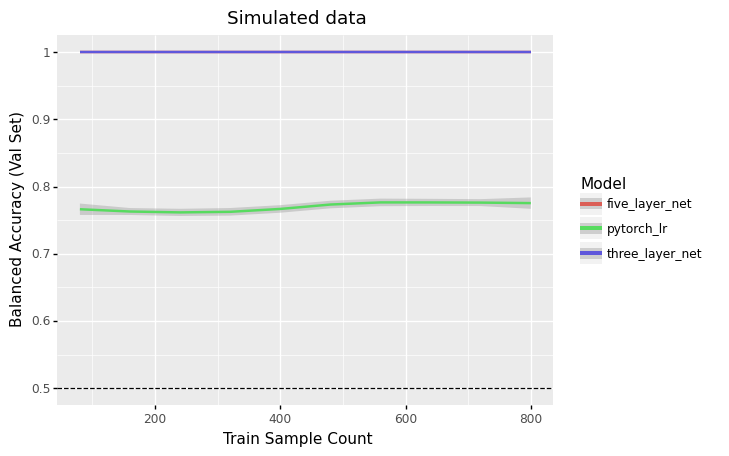

<ggplot: (8754389870745)>

In [52]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated data')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sim_data.svg')
plot

In [53]:
in_files = glob.glob('../../results/sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/sim-data-signal-removed.pytorch_supervised_1.tsv', '../../results/sim-data-signal-removed.pytorch_lr_2.tsv', '../../results/sim-data-signal-removed.pytorch_supervised_2.tsv', '../../results/sim-data-signal-removed.pytorch_supervised_0.tsv', '../../results/sim-data-signal-removed.logistic_regression_2.tsv']


In [54]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sim_data_signal_removed.svg


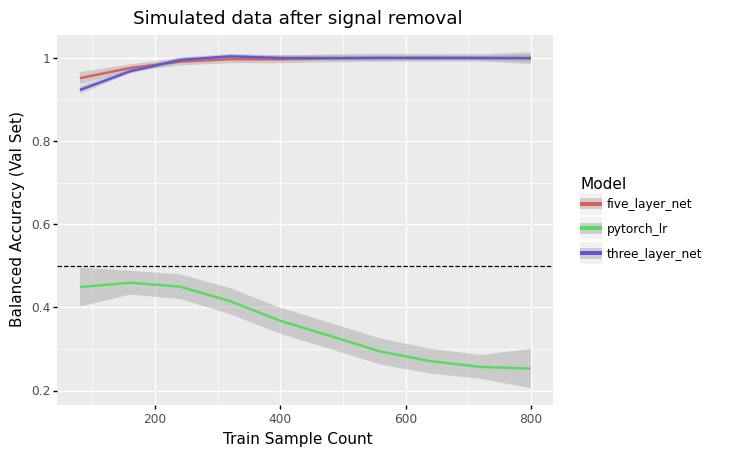

<ggplot: (8754347744905)>

In [55]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data after signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sim_data_signal_removed.svg')
plot

In [56]:
in_files = glob.glob('../../results/no-signal-sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data.deep_net_0.tsv', '../../results/no-signal-sim-data.pytorch_supervised_2.tsv', '../../results/no-signal-sim-data.pytorch_supervised_0.tsv', '../../results/no-signal-sim-data.logistic_regression_2.tsv', '../../results/no-signal-sim-data.deep_net_2.tsv']


In [57]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim.svg


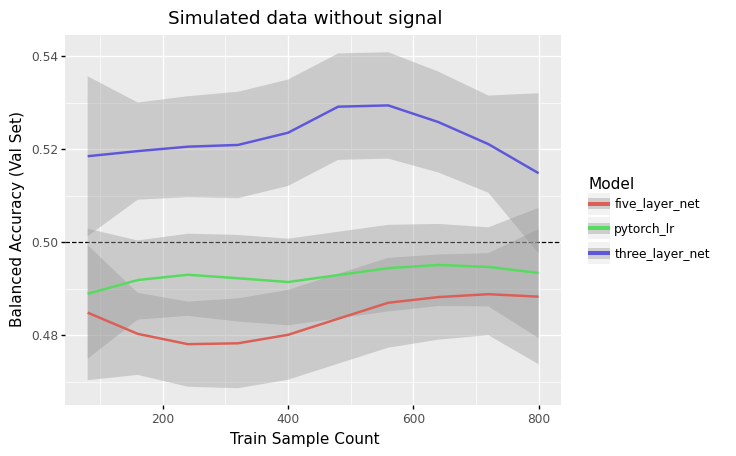

<ggplot: (8754345711865)>

In [58]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data without signal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim.svg')
plot

In [59]:
in_files = glob.glob('../../results/no-signal-sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data-signal-removed.logistic_regression_2.tsv', '../../results/no-signal-sim-data-signal-removed.logistic_regression_1.tsv', '../../results/no-signal-sim-data-signal-removed.pytorch_lr_1.tsv', '../../results/no-signal-sim-data-signal-removed.pytorch_lr_0.tsv', '../../results/no-signal-sim-data-signal-removed.logistic_regression_0.tsv']


In [60]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1]) 
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim_signal_removed.svg


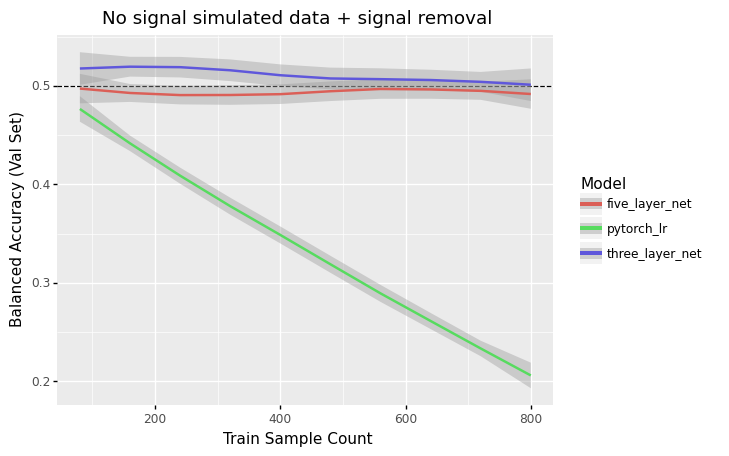

<ggplot: (8754347797601)>

In [61]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('No signal simulated data + signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim_signal_removed.svg')
plot

In [62]:
in_files = glob.glob('../../results/no-signal-sim-data-split-signal.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data-split-signal.logistic_regression_2.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_lr_1.tsv', '../../results/no-signal-sim-data-split-signal.logistic_regression_0.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_supervised_2.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_lr_0.tsv']


In [63]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-split-signal.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim_split_signal.svg


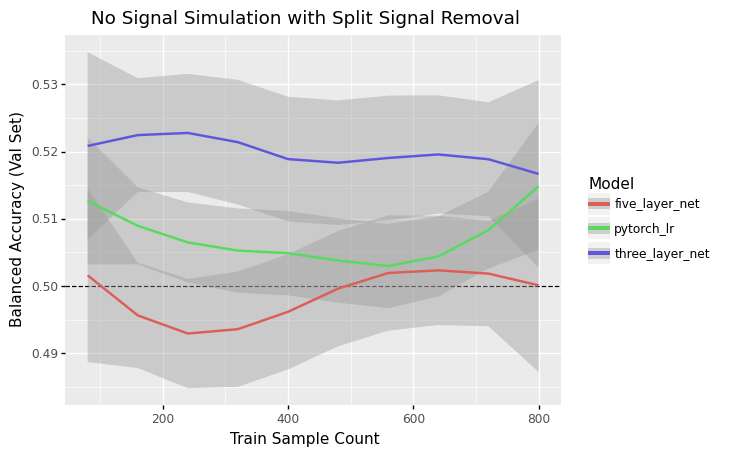

<ggplot: (8754345631829)>

In [64]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('No Signal Simulation with Split Signal Removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim_split_signal.svg')
plot

### Split signal removal (be correction in train and val sets separately)

In [65]:
in_files = glob.glob('../../results/sim-data-split-signal.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/sim-data-split-signal.pytorch_supervised_1.tsv', '../../results/sim-data-split-signal.pytorch_lr_1.tsv', '../../results/sim-data-split-signal.pytorch_lbfgs_0.tsv', '../../results/sim-data-split-signal.pytorch_supervised_2.tsv', '../../results/sim-data-split-signal.logistic_regression_0.tsv']


In [66]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-split-signal.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.93,0.938053,"sample_260_study,sample_236_study,sample_702_s...","sample_41,sample_577,sample_873,sample_723,sam...","sample_11,sample_13,sample_17,sample_19,sample...",80,0.1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,1,80
1,1.00,1.000000,"sample_420_study,sample_260_study,sample_236_s...","sample_41,sample_577,sample_873,sample_723,sam...","sample_11,sample_13,sample_17,sample_19,sample...",160,0.2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,1,160
2,1.00,1.000000,"sample_420_study,sample_634_study,sample_604_s...","sample_41,sample_577,sample_873,sample_723,sam...","sample_11,sample_13,sample_17,sample_19,sample...",240,0.3,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,1,240
3,1.00,1.000000,"sample_672_study,sample_691_study,sample_830_s...","sample_41,sample_577,sample_873,sample_723,sam...","sample_11,sample_13,sample_17,sample_19,sample...",320,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,1,320
4,1.00,1.000000,"sample_103_study,sample_672_study,sample_691_s...","sample_41,sample_577,sample_873,sample_723,sam...","sample_11,sample_13,sample_17,sample_19,sample...",400,0.5,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,1,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,1.00,1.000000,"sample_995_study,sample_27_study,sample_267_st...","sample_65,sample_768,sample_670,sample_303,sam...","sample_1,sample_5,sample_11,sample_15,sample_1...",480,0.6,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,2,480
46,1.00,1.000000,"sample_362_study,sample_995_study,sample_27_st...","sample_65,sample_768,sample_670,sample_303,sam...","sample_1,sample_5,sample_11,sample_15,sample_1...",560,0.7,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,2,560
47,1.00,1.000000,"sample_362_study,sample_995_study,sample_796_s...","sample_65,sample_768,sample_670,sample_303,sam...","sample_1,sample_5,sample_11,sample_15,sample_1...",640,0.8,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,2,640
48,1.00,1.000000,"sample_362_study,sample_995_study,sample_796_s...","sample_65,sample_768,sample_670,sample_303,sam...","sample_1,sample_5,sample_11,sample_15,sample_1...",720,0.9,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,2,720


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sim_split_signal_removal.svg


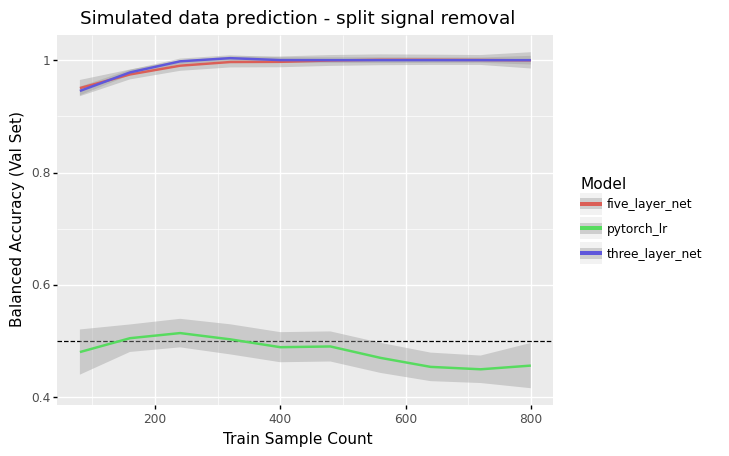

<ggplot: (8754348035997)>

In [67]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - split signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sim_split_signal_removal.svg')
plot

## Linear signal only simulation

In [68]:
in_files = glob.glob('../../results/linear-sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/linear-sim-data.pytorch_lr_2.tsv', '../../results/linear-sim-data.pytorch_supervised_0.tsv', '../../results/linear-sim-data.pytorch_lr_1.tsv', '../../results/linear-sim-data.pytorch_supervised_1.tsv', '../../results/linear-sim-data.pytorch_lr_0.tsv']


In [69]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('linear-sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/linear_sim.svg


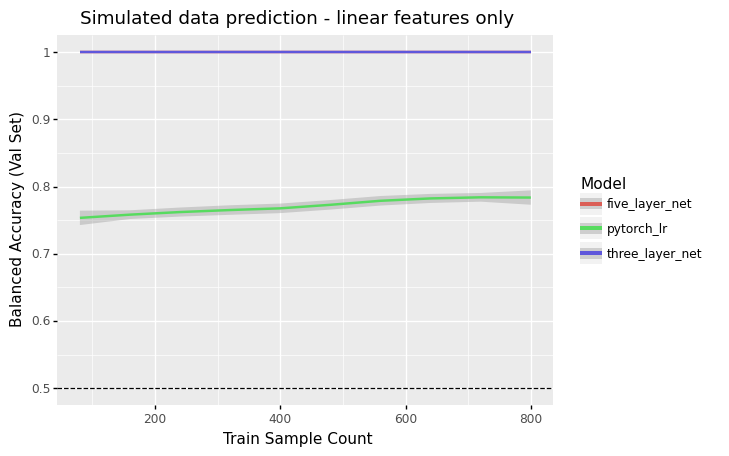

<ggplot: (8754389858453)>

In [70]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - linear features only')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/linear_sim.svg')
plot

In [71]:
in_files = glob.glob('../../results/linear-sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/linear-sim-data-signal-removed.logistic_regression_0.tsv', '../../results/linear-sim-data-signal-removed.deep_net_0.tsv', '../../results/linear-sim-data-signal-removed.deep_net_1.tsv', '../../results/linear-sim-data-signal-removed.deep_net_2.tsv', '../../results/linear-sim-data-signal-removed.pytorch_lr_0.tsv']


In [72]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.425,0.468182,"sample_934_study,sample_542_study,sample_723_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",80,0.1,"0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",logistic_regression,0,80
1,0.305,0.329798,"sample_934_study,sample_103_study,sample_542_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",160,0.2,"0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,0,1,0,0,1,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",logistic_regression,0,160
2,0.205,0.216667,"sample_934_study,sample_103_study,sample_542_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",240,0.3,"1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",logistic_regression,0,240
3,0.190,0.203030,"sample_542_study,sample_943_study,sample_253_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",320,0.4,"1,0,0,1,1,0,0,0,1,0,1,1,1,1,1,1,0,0,1,1,1,1,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",logistic_regression,0,320
4,0.170,0.180808,"sample_542_study,sample_511_study,sample_943_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",400,0.5,"1,0,0,1,1,0,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",logistic_regression,0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.485,0.485699,"sample_315_study,sample_799_study,sample_177_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",480,0.6,"1,0,0,1,1,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,480
46,0.485,0.486299,"sample_315_study,sample_930_study,sample_799_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",560,0.7,"1,0,0,1,1,0,1,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,560
47,0.450,0.450045,"sample_315_study,sample_930_study,sample_799_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",640,0.8,"1,1,0,0,1,0,1,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,640
48,0.530,0.533453,"sample_473_study,sample_315_study,sample_93_st...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",720,0.9,"1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,720


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/linear_sim_signal_removed.svg


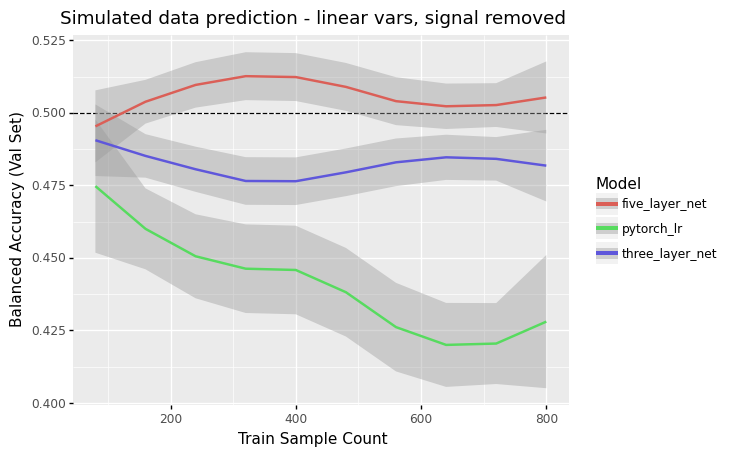

<ggplot: (8754348143365)>

In [73]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - linear vars, signal removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/linear_sim_signal_removed.svg')
plot

In [74]:
in_files = glob.glob('../../results/linear-sim-data-split-signal.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/linear-sim-data-split-signal.pytorch_lr_0.tsv', '../../results/linear-sim-data-split-signal.deep_net_2.tsv', '../../results/linear-sim-data-split-signal.pytorch_lr_1.tsv', '../../results/linear-sim-data-split-signal.pytorch_supervised_2.tsv', '../../results/linear-sim-data-split-signal.pytorch_supervised_0.tsv']


In [75]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('linear-sim-data-split-signal.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/linear_sim_split_signal_removal.svg


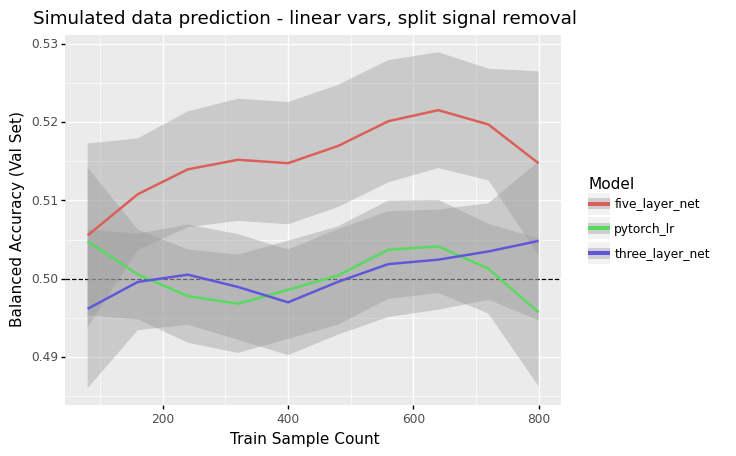

<ggplot: (8754390781965)>

In [76]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - linear vars, split signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/linear_sim_split_signal_removal.svg')
plot

### Combined Sim Figure

In [77]:
in_files = glob.glob('../../results/linear-sim*.tsv')
in_files.extend(glob.glob('../../results/no-signal-sim*.tsv'))
in_files.extend(glob.glob('../../results/sim-data*.tsv'))

In [78]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    if 'linear-sim-data-signal-removed.' in path:
        model_info = path.strip('.tsv').split('linear-sim-data-signal-removed.')[-1]
        new_df['correction'] = 'Signal Removed'
        new_df['simulation'] = 'Linear Sim'
    elif 'linear-sim-data.' in path:
        model_info = path.strip('.tsv').split('linear-sim-data.')[-1]
        new_df['correction'] = 'Full Signal'
        new_df['simulation'] = 'Linear Sim'
    elif '/sim-data.' in path:
        model_info = path.strip('.tsv').split('sim-data.')[-1]
        new_df['correction'] = 'Full Signal'
        new_df['simulation'] = 'Nonlinear Sim'
    elif '/sim-data-signal-removed.' in path:
        model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
        new_df['correction'] = 'Signal Removed'
        new_df['simulation'] = 'Nonlinear Sim'
    elif 'no-signal-sim-data.' in path:
        model_info = path.strip('.tsv').split('no-signal-sim-data.')[-1]
        new_df['correction'] = 'Full Signal'
        new_df['simulation'] = 'Random Sim'
    elif 'no-signal-sim-data-signal-removed.' in path:
        model_info = path.strip('.tsv').split('no-signal-sim-data-signal-removed.')[-1]
        new_df['correction'] = 'Signal Removed'
        new_df['simulation'] = 'Random Sim'
    else:
        continue
    model_info = model_info.split('_')    
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/simulated_data_combined.svg


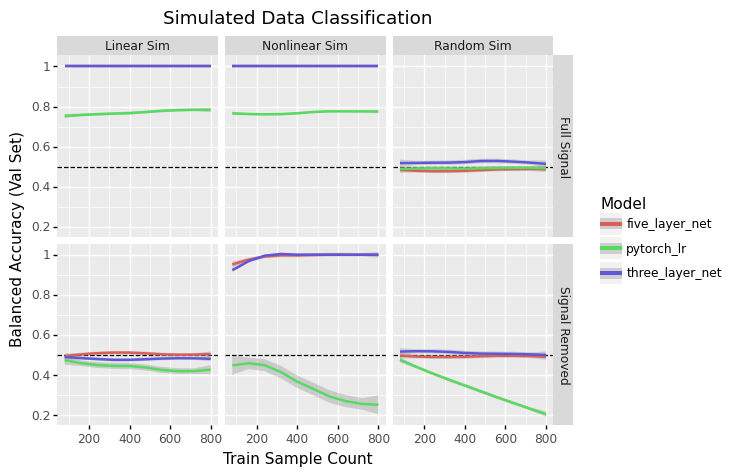

<ggplot: (8754390799425)>

In [79]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated Data Classification')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['correction', 'simulation'], scales='fixed')
plot.save('../../figures/simulated_data_combined.svg')
plot

## Unused Plots 

In [80]:
top_five_tissues = ['Blood', 'Breast', 'Stem_Cell', 'Cervix', 'Brain']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Stem_Cell'), ('Blood', 'Cervix')]

In [81]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

720

In [82]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'three_layer_net')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'five_layer_net')
run_results

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,tissue1,tissue2,correction_method,pair,train_count
0,0.772692,0.500000,"SRP030401,SRP026013,SRP011192,SRP034528,SRP001...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",464,0.1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,Blood-Breast,464
1,0.772692,0.500000,"SRP007412,SRP032456,SRP030401,SRP026013,SRP002...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",928,0.2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,Blood-Breast,928
2,0.790535,0.539249,"SRP007412,SRP032456,SRP030401,SRP018312,SRP026...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1393,0.3,"0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,1,1,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,Blood-Breast,1393
3,0.772692,0.500000,"SRP007412,SRP032456,SRP030401,SRP018312,SRP026...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1857,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,Blood-Breast,1857
4,0.278510,0.533133,"SRP007412,SRP032456,SRP030401,SRP018312,SRP026...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",2322,0.5,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,Blood-Breast,2322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.379121,0.496429,"SRP010374,SRP011085,SRP017966,SRP007412,SRP026...","SRR1264255,SRR1237993,SRR1521382,SRR1017170,SR...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",606,0.6,"1,0,1,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1,1,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,606
46,0.219780,0.476190,"SRP010374,SRP011085,SRP017966,SRP007412,SRP026...","SRR1264255,SRR1237993,SRR1521382,SRR1017170,SR...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",707,0.7,"1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,707
47,0.769231,0.516667,"SRP010374,SRP011085,SRP017966,SRP007412,SRP026...","SRR1264255,SRR1237993,SRR1521382,SRR1017170,SR...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",808,0.8,"0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,808
48,0.456044,0.579762,"SRP010374,SRP011085,SRP017966,SRP007412,SRP026...","SRR1264255,SRR1237993,SRR1521382,SRR1017170,SR...","SRR309282,SRR309283,SRR309284,SRR309289,SRR036...",909,0.9,"1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,...","1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...","{""Brain"": 0, ""Cervix"": 1}",pytorch_lr,0,Brain,Cervix,study_corrected,Brain-Cervix,909


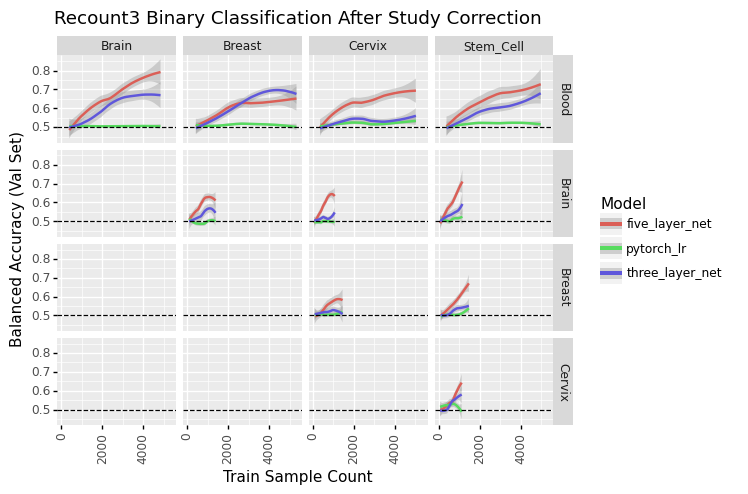

<ggplot: (8754345371585)>

In [83]:
plot_df = run_results[run_results['correction_method'] == 'study_corrected']
plot_df = plot_df[plot_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')

plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification After Study Correction')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot

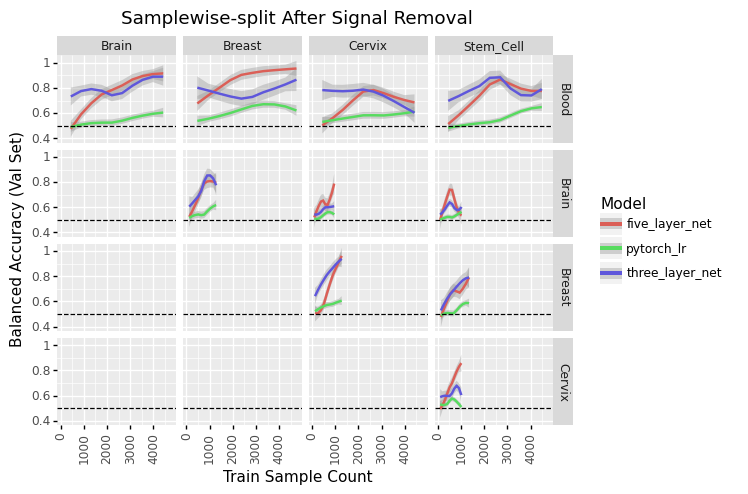

<ggplot: (8754344757049)>

In [84]:
plot_df = run_results[run_results['correction_method'] == 'signal_removed_sample_level']
plot_df = plot_df[plot_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Pairwise comparisons tissue signal removed (sample level split)')

plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Samplewise-split After Signal Removal')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot
plot

## Tissue Prediction

In [85]:
in_files = glob.glob('../../results/Blood.Breast.*.tsv')
print(in_files[:5])

['../../results/Blood.Breast.batch-skl-lr_0.tsv', '../../results/Blood.Breast.deep_net_0-signal_removed_sample_level.tsv', '../../results/Blood.Breast.pytorch_lr_1-signal_removed_sample_level.tsv', '../../results/Blood.Breast.logistic_regression_2-study_corrected.tsv', '../../results/Blood.Breast.deep_net_2-study_corrected.tsv']


In [86]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    new_df['tissue1'] = tissue1
    new_df['tissue2'] = tissue2
    new_df['correction_method'] = correction_method
    
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,tissue1,tissue2,correction_method,train_count
0,0.772692,0.500000,"SRP030401,SRP026013,SRP011192,SRP034528,SRP001...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",464,0.1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,464
1,0.772692,0.500000,"SRP007412,SRP032456,SRP030401,SRP026013,SRP002...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",928,0.2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,928
2,0.790535,0.539249,"SRP007412,SRP032456,SRP030401,SRP018312,SRP026...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1393,0.3,"0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,1,1,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,1393
3,0.772692,0.500000,"SRP007412,SRP032456,SRP030401,SRP018312,SRP026...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1857,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,1857
4,0.278510,0.533133,"SRP007412,SRP032456,SRP030401,SRP018312,SRP026...","DRR006419,SRR1036102,SRR1027171,SRR1174331,SRR...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",2322,0.5,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,...","{""Blood"": 0, ""Breast"": 1}",,batch,Blood,Breast,unmodified,2322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.641900,0.500576,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3067,0.6,"1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,3067
46,0.628502,0.527208,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3578,0.7,"1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,3578
47,0.599269,0.508803,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",4089,0.8,"1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,4089
48,0.626066,0.541016,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",4600,0.9,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,1,Blood,Breast,study_corrected,4600


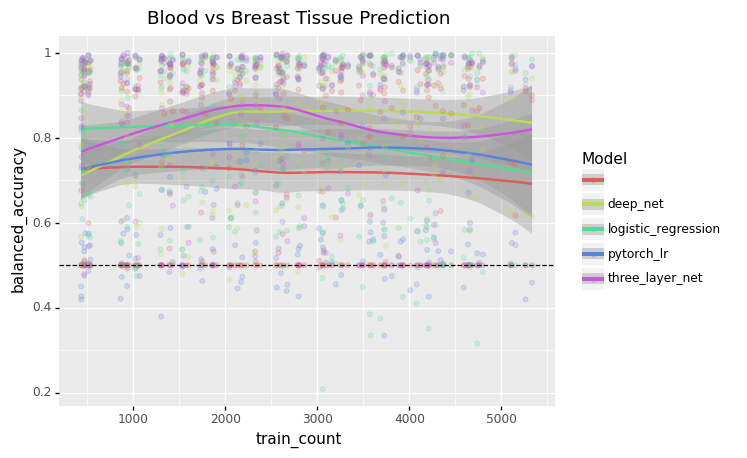

<ggplot: (8754389887853)>

In [87]:
plot_df = tissue_metrics[tissue_metrics['correction_method'] == 'unmodified']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Blood vs Breast Tissue Prediction')
plot

### BE Corrected binary tissue classification

In [88]:
in_files = glob.glob('../../results/Blood.Breast.*.tsv')
in_files = [f for f in in_files if 'study_corrected' in f]
print(in_files[:5])

['../../results/Blood.Breast.logistic_regression_2-study_corrected.tsv', '../../results/Blood.Breast.deep_net_2-study_corrected.tsv', '../../results/Blood.Breast.pytorch_lr_2-study_corrected.tsv', '../../results/Blood.Breast.deep_net_0-study_corrected.tsv', '../../results/Blood.Breast.pytorch_supervised_1-study_corrected.tsv']


In [89]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('Breast.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.694118,0.524138,"SRP009615,SRP011278,SRP030401,SRP002128,SRP041...","SRR1060773,SRR2052820,ERR204991,SRR1060755,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",465,0.1,"0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,465
1,0.679216,0.556162,"SRP009615,SRP011278,SRP005846,SRP030401,SRP015...","SRR1060773,SRR2052820,ERR204991,SRR1060755,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",931,0.2,"0,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,931
2,0.720000,0.597881,"SRP009615,SRP011278,SRP005846,SRP030401,DRP001...","SRR1060773,SRR2052820,ERR204991,SRR1060755,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1397,0.3,"0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,1397
3,0.683137,0.562204,"SRP009615,SRP011278,SRP005846,SRP030401,DRP001...","SRR1060773,SRR2052820,ERR204991,SRR1060755,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",1863,0.4,"0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,1863
4,0.685490,0.567220,"SRP009615,SRP011278,SRP007403,SRP005846,SRP030...","SRR1060773,SRR2052820,ERR204991,SRR1060755,SRR...","SRR941861,SRR1313200,SRR1313100,SRR1313101,SRR...",2329,0.5,"0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,2329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.641900,0.500576,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3067,0.6,"1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,3067
46,0.628502,0.527208,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",3578,0.7,"1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,3578
47,0.599269,0.508803,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",4089,0.8,"1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,4089
48,0.626066,0.541016,"SRP015138,SRP029888,SRP029262,SRP029990,SRP041...","SRR2049707,ERR205016,ERR188225,SRR1656583,SRR0...","SRR306844,SRR306845,SRR306846,SRR1106084,SRR11...",4600,0.9,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,...","{""Blood"": 0, ""Breast"": 1}",logistic_regression,corrected,4600


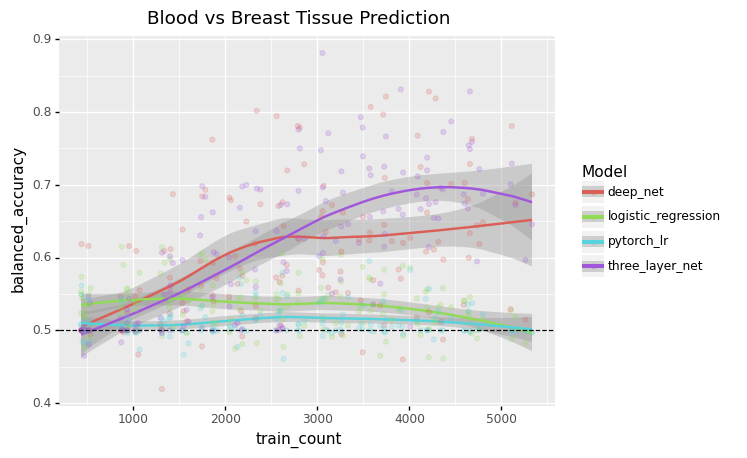

<ggplot: (8754348186605)>

In [90]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Blood vs Breast Tissue Prediction')
plot

## Imputation pretraining

In [91]:
in_files = glob.glob('../../results/tissue_impute.*.tsv')
print(in_files[:5])

['../../results/tissue_impute.five_layer_impute_1.tsv', '../../results/tissue_impute.five_layer_impute_2.tsv', '../../results/tissue_impute.three_layer_impute_1.tsv', '../../results/tissue_impute.three_layer_impute_0.tsv', '../../results/tissue_impute.three_layer_impute_2.tsv']


In [92]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tissue_impute.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics = tissue_metrics.rename({'impute_samples': 'pretraining_sample_count'}, axis='columns')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,pretraining_sample_count,Model,seed,train_count
0,0.327108,0.063728,"SRP005281,SRP012656,SRP031858,SRP009790,SRP017...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",993,0.1,0,five_layer,1,993
1,0.377082,0.145956,"SRP005281,SRP012656,SRP031858,SRP009790,SRP017...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",993,0.1,17320,five_layer,1,993
2,0.356890,0.124458,"SRP021214,SRP026042,SRP015640,SRP032743,SRP023...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",1987,0.2,0,five_layer,1,1987
3,0.379101,0.139422,"SRP021214,SRP026042,SRP015640,SRP032743,SRP023...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",1987,0.2,17320,five_layer,1,1987
4,0.570924,0.216153,"SRP021214,SRP026042,SRP015640,SRP032743,SRP023...","SRR1107926,SRR2052744,ERR752538,SRR1608736,SRR...","SRR960409,SRR960410,SRR960411,SRR960412,SRR954...",2981,0.3,0,five_layer,1,2981
...,...,...,...,...,...,...,...,...,...,...,...
95,0.605626,0.409489,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",8027,0.8,17320,five_layer,0,8027
96,0.494692,0.324735,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",9030,0.9,0,five_layer,0,9030
97,0.609873,0.388163,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",9030,0.9,17320,five_layer,0,9030
98,0.341295,0.121709,"SRP027358,SRP001462,SRP041159,SRP041255,SRP035...","SRR1608532,SRR1608638,SRR1223570,SRR1661828,SR...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",10034,1.0,0,five_layer,0,10034


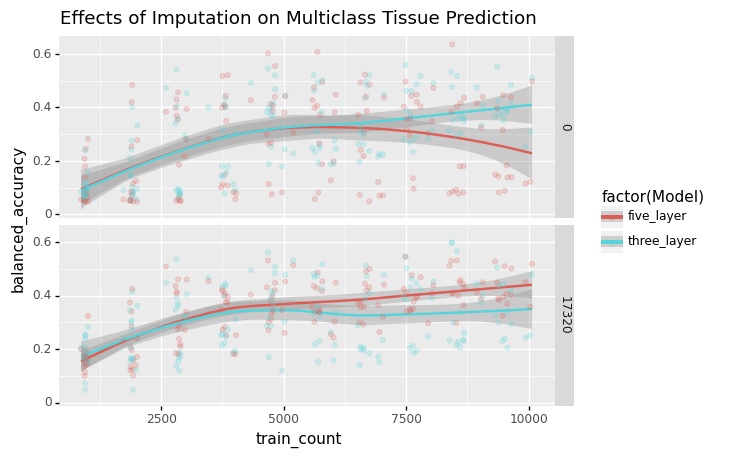

<ggplot: (8754348186593)>

In [93]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='factor(Model)')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Effects of Imputation on Multiclass Tissue Prediction')
plot += facet_grid('pretraining_sample_count ~ .')
plot

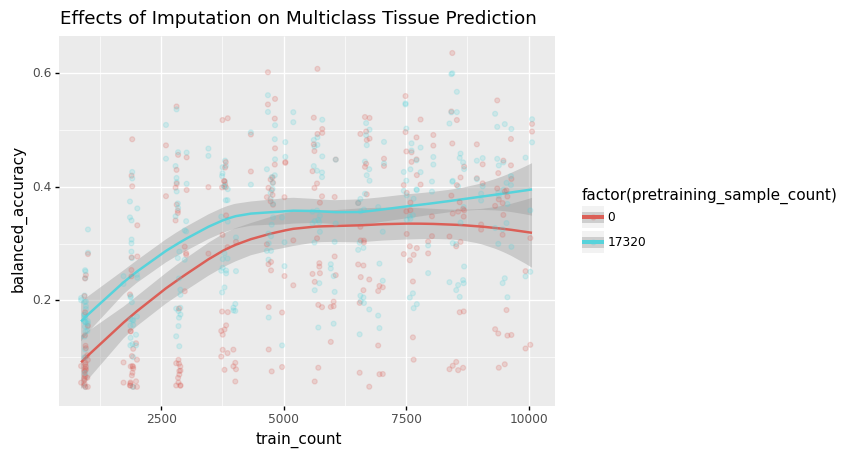

<ggplot: (8754390149405)>

In [94]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='factor(pretraining_sample_count)')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Effects of Imputation on Multiclass Tissue Prediction')
plot

## Sample split positive control

In [95]:
in_files = glob.glob('../../results/sample-split.*.tsv')
print(in_files[:5])

['../../results/sample-split.deep_net_2.tsv', '../../results/sample-split.pytorch_lr_0.tsv', '../../results/sample-split.pytorch_lr_2.tsv', '../../results/sample-split.deep_net_1.tsv', '../../results/sample-split.pytorch_supervised_0.tsv']


In [96]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.739933,0.699252,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,pretrained,"0,0,0,2,9,5,16,6,16,13,12,0,0,14,9,0,0,0,10,15...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
1,0.123742,0.167131,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,not_pretrained,"18,13,19,13,18,13,16,13,13,13,13,18,2,14,14,10...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
2,0.862836,0.807580,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,pretrained,"0,0,0,0,9,5,17,6,11,14,12,0,16,14,9,0,0,0,10,1...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
3,0.064178,0.087515,"SRP041255,SRP021916,SRP041751,SRP022133,SRP044...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,not_pretrained,"18,18,19,19,16,16,19,19,16,19,19,18,16,16,19,2...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
4,0.864094,0.738800,"SRP041255,SRP041751,SRP044668,SRP011130,SRP050...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",1429,0.3,pretrained,"0,0,0,0,9,5,17,6,17,14,12,0,16,14,9,0,0,0,10,1...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,1429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.691565,0.366099,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",3813,0.8,not_pretrained,"0,12,0,11,17,0,3,0,4,4,3,0,12,11,11,0,3,17,11,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,3813
96,0.849350,0.702431,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,pretrained,"0,12,0,11,17,0,17,0,14,7,3,0,12,4,20,16,3,4,4,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
97,0.771297,0.625953,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,not_pretrained,"0,12,0,11,17,0,3,0,4,7,3,0,12,4,4,16,3,4,4,19,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
98,0.850608,0.691270,"SRP021524,SRP006474,SRP019936,SRP026044,SRP034...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4767,1.0,pretrained,"0,12,0,11,17,0,4,0,14,11,3,0,12,4,20,16,3,4,4,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4767


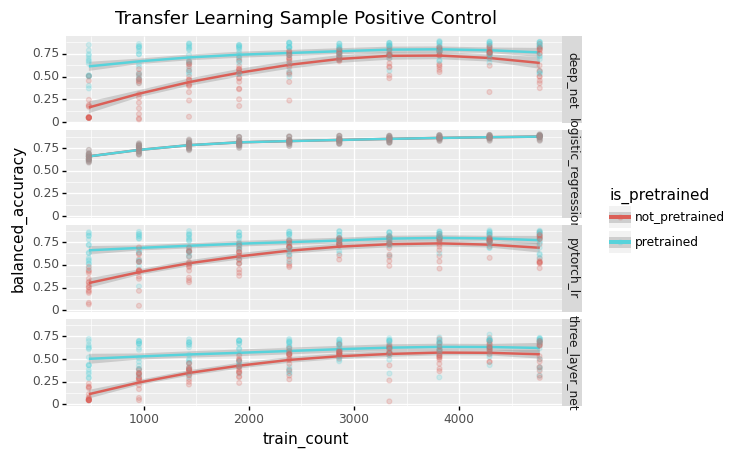

<ggplot: (8754345598985)>

In [97]:
plot = ggplot(tissue_metrics, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Transfer Learning Sample Positive Control')
plot += facet_grid('Model ~ .')
plot

In [98]:
single_run_df = tissue_metrics[tissue_metrics['seed'] == '1']
single_run_df.head()

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.318792,0.397974,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",476,0.1,pretrained,"17,6,8,3,17,19,19,19,19,19,5,19,19,0,5,2,12,19...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,476
1,0.012584,0.044643,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",476,0.1,not_pretrained,"16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,1...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,476
2,0.513003,0.538237,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",953,0.2,pretrained,"17,3,8,17,2,14,20,0,0,0,14,19,0,0,16,2,7,0,14,...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,953
3,0.412752,0.473722,"SRP016568,SRP035988,SRP018716,SRP015668,SRP044...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",953,0.2,not_pretrained,"17,3,8,3,15,14,20,0,0,0,14,0,19,2,16,2,9,19,14...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,953
4,0.470218,0.544888,"SRP018716,SRP015668,ERP009437,SRP030475,SRP019...","SRR1265498,ERR188091,SRR1951659,SRR1551031,SRR...","SRR1015684,SRR541414,ERR752590,SRR1238530,SRR0...",1429,0.3,pretrained,"17,6,8,3,15,14,20,0,0,0,14,19,0,19,5,16,9,0,3,...","17,9,8,17,4,0,0,0,0,0,14,0,0,0,0,0,9,0,11,0,5,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,1,1429


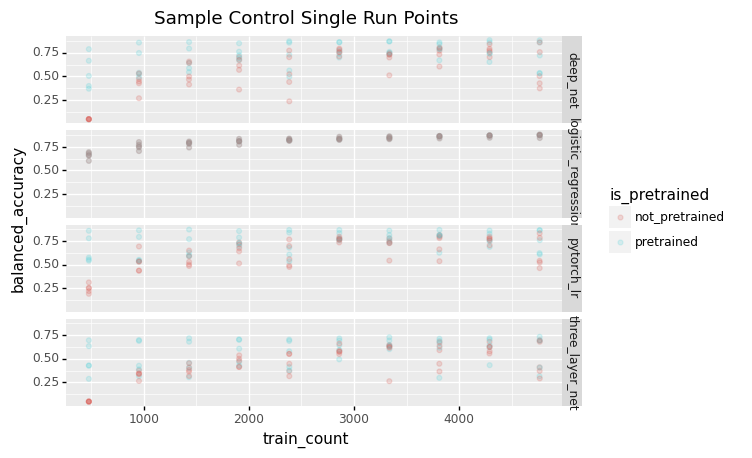

<ggplot: (8754390004037)>

In [99]:
plot = ggplot(single_run_df, aes(x='train_count', y='balanced_accuracy', color='is_pretrained')) 
#plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sample Control Single Run Points')
plot += facet_grid('Model ~ .')
plot

## Tissue Signal Removed

### Sample level

In [100]:
in_files = glob.glob('../../results/sample-split-signal-removed.*.tsv')
print(in_files[:5])

['../../results/sample-split-signal-removed.logistic_regression_2.tsv', '../../results/sample-split-signal-removed.pytorch_lr_0.tsv', '../../results/sample-split-signal-removed.deep_net_1.tsv', '../../results/sample-split-signal-removed.logistic_regression_1.tsv', '../../results/sample-split-signal-removed.logistic_regression_0.tsv']


In [101]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv')
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')

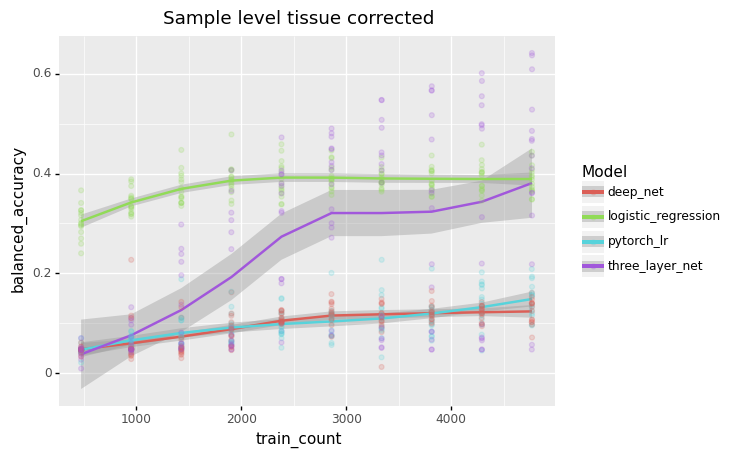

<ggplot: (8754345092157)>

In [102]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sample level tissue corrected')
plot

### Study level

In [103]:
in_files = glob.glob('../../results/study-split-signal-removed.*.tsv')
print(in_files[:5])

['../../results/study-split-signal-removed.pytorch_lr_1.tsv', '../../results/study-split-signal-removed.deep_net_1.tsv', '../../results/study-split-signal-removed.pytorch_lr_0.tsv', '../../results/study-split-signal-removed.deep_net_0.tsv', '../../results/study-split-signal-removed.logistic_regression_0.tsv']


In [104]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')

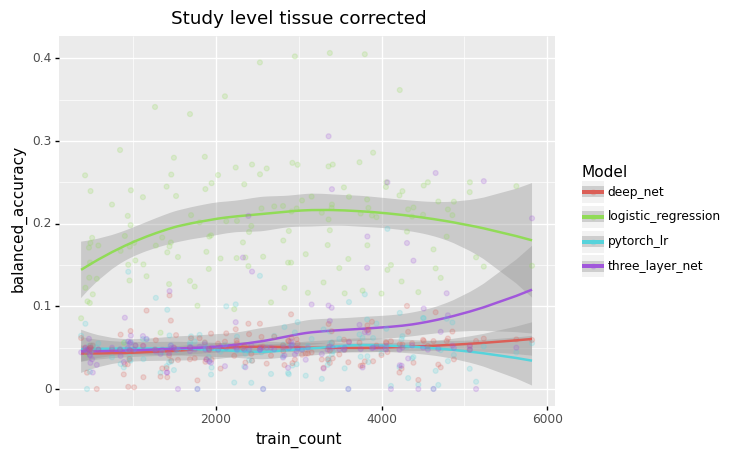

<ggplot: (8754348208921)>

In [105]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Study level tissue corrected')
plot

## Study Signal Removed

### Sample level

In [106]:
in_files = glob.glob('../../results/sample-split-study-corrected.*.tsv')
print(in_files[:5])

['../../results/sample-split-study-corrected.pytorch_supervised_0.tsv', '../../results/sample-split-study-corrected.pytorch_supervised_2.tsv', '../../results/sample-split-study-corrected.deep_net_0.tsv', '../../results/sample-split-study-corrected.pytorch_lr_1.tsv', '../../results/sample-split-study-corrected.deep_net_1.tsv']


In [107]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')

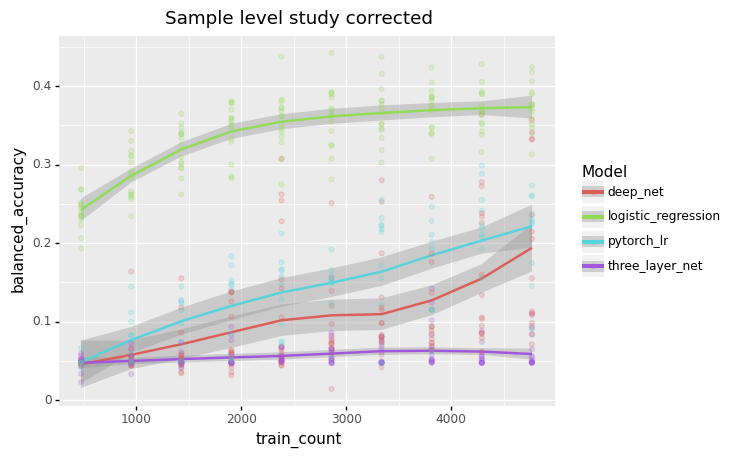

<ggplot: (8754348204513)>

In [108]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Sample level study corrected')
plot

### Study level

In [109]:
in_files = glob.glob('../../results/study-split-study-corrected.*.tsv')
print(in_files[:5])

['../../results/study-split-study-corrected.logistic_regression_1.tsv', '../../results/study-split-study-corrected.logistic_regression_0.tsv', '../../results/study-split-study-corrected.pytorch_supervised_2.tsv', '../../results/study-split-study-corrected.pytorch_lr_2.tsv', '../../results/study-split-study-corrected.logistic_regression_2.tsv']


In [110]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')

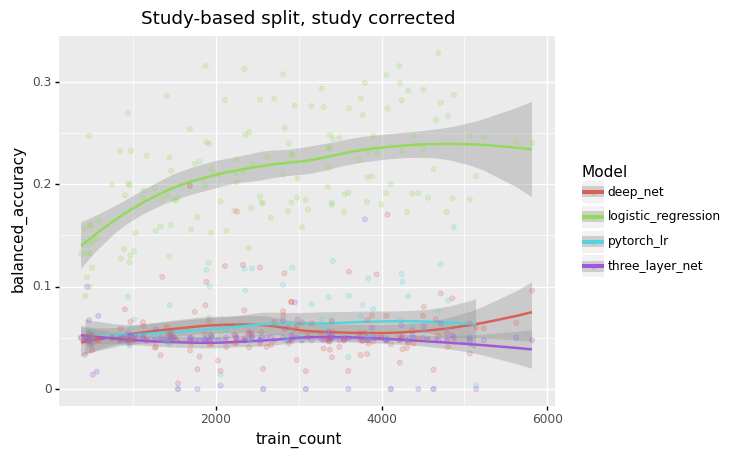

<ggplot: (8754345064533)>

In [111]:
viz_df = tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained']
plot = ggplot(viz_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += ggtitle('Study-based split, study corrected')
plot

## Mutation prediction

In [112]:
in_files = glob.glob('../../results/tcga-binary.*.tsv')
print(in_files[:5])

['../../results/tcga-binary.PIK3CA.deep_net_1.tsv', '../../results/tcga-binary.PIK3CA.logistic_regression_0.tsv', '../../results/tcga-binary.KRAS.pytorch_supervised_1.tsv', '../../results/tcga-binary.KRAS.pytorch_lr_1.tsv', '../../results/tcga-binary.KRAS.pytorch_lr_0.tsv']


In [113]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tcga-binary.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model.split('.')[-1]
    new_df['gene'] = supervised_model.split('.')[0]
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/tcga.svg


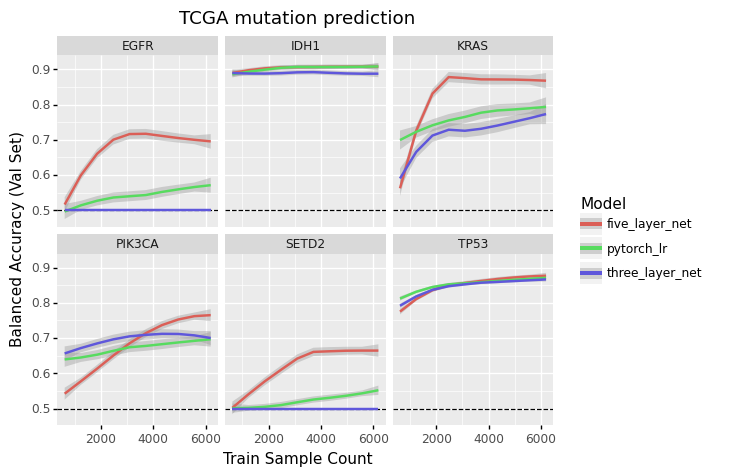

<ggplot: (8754389743581)>

In [114]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
#plot += geom_point(alpha=.2)
plot += facet_wrap(['gene'])
plot += ggtitle('TCGA mutation prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/tcga.svg')
plot

In [115]:
in_files = glob.glob('../../results/tcga-binary-signal-removed.*.tsv')
print(in_files[:5])

['../../results/tcga-binary-signal-removed.TP53.pytorch_lr_2.tsv', '../../results/tcga-binary-signal-removed.TP53.logistic_regression_2.tsv', '../../results/tcga-binary-signal-removed.IDH1.pytorch_lr_2.tsv', '../../results/tcga-binary-signal-removed.KRAS.pytorch_lr_2.tsv', '../../results/tcga-binary-signal-removed.TP53.deep_net_0.tsv']


In [116]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tcga-binary-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model.split('.')[-1]
    new_df['gene'] = supervised_model.split('.')[0]
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/tcga_signal_removed.svg


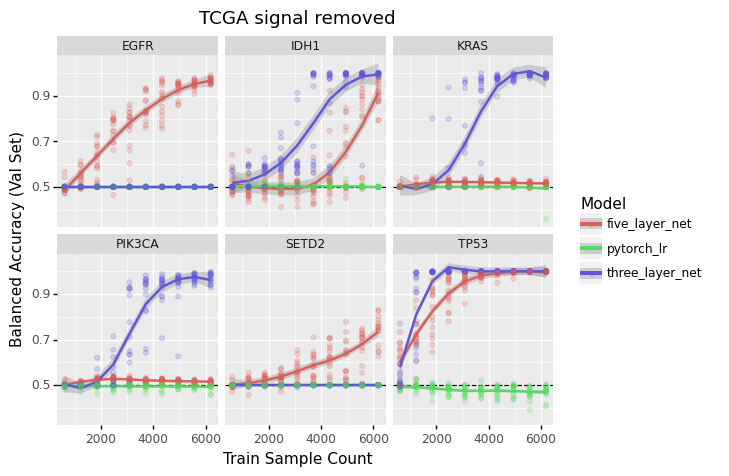

<ggplot: (8754344743397)>

In [117]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += facet_wrap(['gene'])
plot += ggtitle('TCGA signal removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/tcga_signal_removed.svg')
plot

In [118]:
in_files = glob.glob('../../results/tcga-binary-split-signal.*.tsv')
print(in_files[:5])

['../../results/tcga-binary-split-signal.KRAS.pytorch_supervised_1.tsv', '../../results/tcga-binary-split-signal.SETD2.pytorch_lr_2.tsv', '../../results/tcga-binary-split-signal.IDH1.deep_net_1.tsv', '../../results/tcga-binary-split-signal.SETD2.logistic_regression_1.tsv', '../../results/tcga-binary-split-signal.PIK3CA.logistic_regression_0.tsv']


In [119]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tcga-binary-split-signal.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model.split('.')[-1]
    new_df['gene'] = supervised_model.split('.')[0]
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/tcga_split_signal.svg


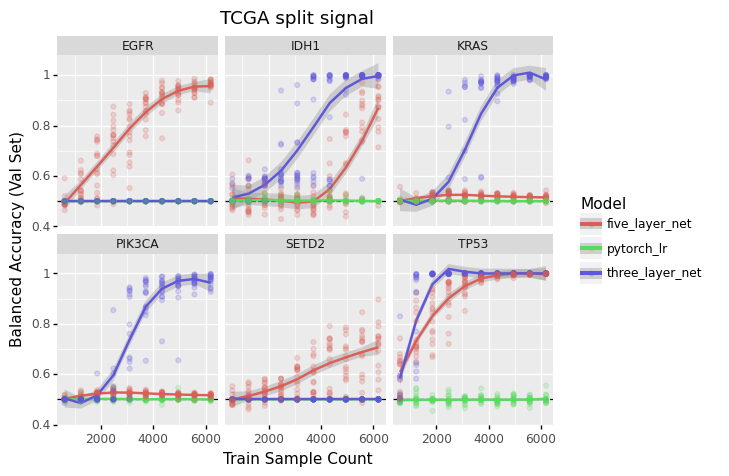

<ggplot: (8754344981937)>

In [120]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += facet_wrap(['gene'])
plot += ggtitle('TCGA split signal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/tcga_split_signal.svg')
plot